In [5]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
import pytorch_lightning as pl
from torch.utils.data import Dataset, random_split, DataLoader
from pytorch_lightning import Trainer

import glob

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from typing import Any, Tuple, Optional, Callable

In [8]:
os.chdir("/Users/sofija/Ai4er/mres/tree-segmentation" )
os.getcwd()

'/Users/sofija/Ai4er/mres/tree-segmentation'

In [9]:
from src.datasets import TreeSegments

In [286]:
### TODO: 

# does it make any sense to have three (RGB) channels for the depth map? 

## Calculate the mean and standard dev of the dataset

In [95]:
augs = transforms.Compose([transforms.ToTensor(), 
                           transforms.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),])

In [119]:
class TreeDataset(torch.utils.data.Dataset):
    """Class defining procedure to load ARCore depth maps
    """
    
    def __init__(self,
                 depth_dir: str,
                 train: bool = True,
                 transform: Optional[Callable] = None,):
        # Initialize list of relative path to each image
        self.depth_paths = [os.path.join(depth_dir, file_name) for file_name in listdir_nohidden(depth_dir)]
        self.train = train
        self.transform = transform
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:

        depth_path = self.depth_paths[idx]
        img = Image.open(depth_path)

        # Apply transform and return
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __len__(self):
        # Length corresponds to total number of files
        return len(self.depth_paths)

In [97]:
ds = TreeDataset(depth_dir="../../data/depths/", 
                  transform=augs,
)

In [98]:
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for i in range(len(ds)):
    psum    += ds[i].sum(axis        = [1, 2])
    psum_sq += (ds[i] ** 2).sum(axis = [1, 2])

In [99]:
# pixel count
count = len(ds) * 120 * 160

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.2860, 0.4530, 0.4528])
std:  tensor([0.1852, 0.2681, 0.1247])


## Creating datamodule

In [10]:
from src.datamodules import TreeDataModule

In [11]:
dm = TreeDataModule(data_dir="data/depths/", 
                   target_dir="data/segmented/",
                   )

In [12]:
dm.setup(stage="fit")
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

In [13]:
len(dm.val_dataset)

18

In [16]:
for sample in train_dl:
    image = sample[0]
    mask = sample[1]

In [17]:
image.shape

torch.Size([7, 3, 120, 160])

In [18]:
image.min()

tensor(0.)

In [19]:
mask.shape

torch.Size([7, 1, 120, 160])

In [20]:
mask.max()

tensor(1)

(-0.5, 159.5, 119.5, -0.5)

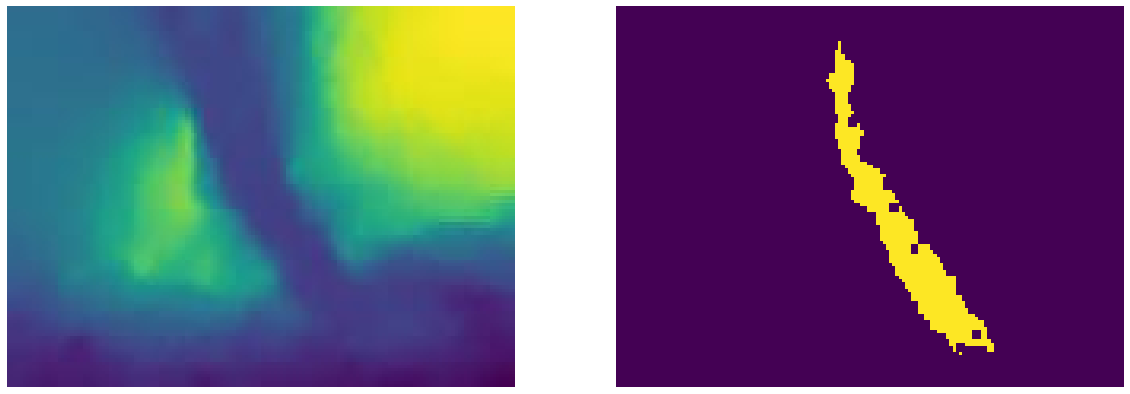

In [22]:
ncols = 2
nrows = 1

sample_n = 1

fig, axs = plt.subplots(
    nrows=1,
    ncols=ncols,
    figsize=(20, ncols * 4),
)
# permute to rearrange the rgb channel to be last 
axs[0].imshow(image[sample_n,:,:,:].permute(1, 2, 0))
axs[0].axis("off")

msk = mask[sample_n, :, :]
msk = torch.squeeze(msk)
axs[1].imshow(msk)
axs[1].axis("off")

In [68]:
# from pl_examples.domain_templates.unet import UNet

In [132]:
import segmentation_models_pytorch as smp

In [191]:
# define binary semantic segmentation task lightning module 

"""Segmentation tasks."""

from typing import Any, Dict, cast
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy
from pytorch_lightning.core.lightning import LightningModule
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, JaccardIndex, MetricCollection

from pytorch_toolbelt.losses import JaccardLoss, BinaryFocalLoss

from torchgeo.datasets.utils import unbind_samples
from torchgeo.models import FCN

# https://github.com/pytorch/pytorch/issues/60979
# https://github.com/pytorch/pytorch/pull/61045
DataLoader.__module__ = "torch.utils.data"


class SemanticSegmentationTask(LightningModule):
    """LightningModule for semantic segmentation of images."""

    def config_task(self) -> None:
        """Configures the task based on kwargs parameters passed to the constructor."""
        if self.hyperparams["segmentation_model"] == "unet":
            self.model = smp.Unet(
                encoder_name=self.hyperparams["encoder_name"],
                encoder_weights=self.hyperparams["encoder_weights"],
                in_channels=self.hyperparams["in_channels"],
                classes=self.hyperparams["num_classes"],
            )
        elif self.hyperparams["segmentation_model"] == "deeplabv3+":
            self.model = smp.DeepLabV3Plus(
                encoder_name=self.hyperparams["encoder_name"],
                encoder_weights=self.hyperparams["encoder_weights"],
                in_channels=self.hyperparams["in_channels"],
                classes=self.hyperparams["num_classes"],
            )
        elif self.hyperparams["segmentation_model"] == "fcn":
            self.model = FCN(
                in_channels=self.hyperparams["in_channels"],
                classes=self.hyperparams["num_classes"],
                num_filters=self.hyperparams["num_filters"],
            )
        else:
            raise ValueError(
                f"Model type '{self.hyperparams['segmentation_model']}' is not valid."
            )

        if self.hyperparams["loss"] == "bce":
            self.loss = nn.BCELoss()
            
#         elif self.hyperparams["loss"] == "jaccard":
            
#             self.losst = JaccardLoss(
            
#             )
            
#             self.loss = smp.losses.JaccardLoss(
#                 mode="multiclass", classes=self.hyperparams["num_classes"]
#             )
#         elif self.hyperparams["loss"] == "focal":
            
#             self.loss = BinaryFocalLoss(
#             )
            
            # self.loss = smp.losses.FocalLoss(
            #     "multiclass", ignore_index=self.ignore_zeros, normalized=True
            # )
        else:
            raise ValueError(f"Loss type '{self.hyperparams['loss']}' is not valid.")

    def __init__(self, **kwargs: Any) -> None:
        """Initialize the LightningModule with a model and loss function.
        Keyword Args:
            segmentation_model: Name of the segmentation model type to use
            encoder_name: Name of the encoder model backbone to use
            encoder_weights: None or "imagenet" to use imagenet pretrained weights in
                the encoder model
            in_channels: Number of channels in input image
            num_classes: Number of semantic classes to predict
            loss: Name of the loss function
            ignore_zeros: Whether to ignore the "0" class value in the loss and metrics
        Raises:
            ValueError: if kwargs arguments are invalid
        """
        super().__init__()

        # Creates `self.hparams` from kwargs
        self.save_hyperparameters()  # type: ignore[operator]
        self.hyperparams = cast(Dict[str, Any], self.hparams)

        self.ignore_zeros = None if kwargs["ignore_zeros"] else 0

        self.config_task()

        self.train_metrics = MetricCollection(
            [
                Accuracy(
                    num_classes=self.hyperparams["num_classes"],
                    ignore_index=self.ignore_zeros,
                ),
                # JaccardIndex(
                #     num_classes=self.hyperparams["num_classes"],
                #     ignore_index=self.ignore_zeros,
                # ),
            ],
            prefix="train_",
        )
        self.val_metrics = self.train_metrics.clone(prefix="val_")
        self.test_metrics = self.train_metrics.clone(prefix="test_")

    def forward(self, *args: Any, **kwargs: Any) -> Any:
        """Forward pass of the model.
        Args:
            x: tensor of data to run through the model
        Returns:
            output from the model
        """
        return self.model(*args, **kwargs)

    def training_step(self, *args: Any, **kwargs: Any) -> Tensor:
        """Compute and return the training loss.
        Args:
            batch: the output of your DataLoader
        Returns:
            training loss
        """
        batch = args[0]
        x = batch["image"]
        y = batch["mask"]
        y_hat = self.forward(x)
        y_hat_hard = y_hat.argmax(dim=1)

        loss = self.loss(y_hat, y)

        # by default, the train step logs every `log_every_n_steps` steps where
        # `log_every_n_steps` is a parameter to the `Trainer` object
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        self.train_metrics(y_hat_hard, y)

        return cast(Tensor, loss)

    def training_epoch_end(self, outputs: Any) -> None:
        """Logs epoch level training metrics.
        Args:
            outputs: list of items returned by training_step
        """
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

    def validation_step(self, *args: Any, **kwargs: Any) -> None:
        """Compute validation loss and log example predictions.
        Args:
            batch: the output of your DataLoader
            batch_idx: the index of this batch
        """
        batch = args[0]
        batch_idx = args[1]
        x = batch["image"]
        y = batch["mask"]
        y_hat = self.forward(x)
        y_hat_hard = y_hat.argmax(dim=1)

        loss = self.loss(y_hat, y)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.val_metrics(y_hat_hard, y)

        if batch_idx < 10:
            try:
                datamodule = self.trainer.datamodule  # type: ignore[attr-defined]
                batch["prediction"] = y_hat_hard
                for key in ["image", "mask", "prediction"]:
                    batch[key] = batch[key].cpu()
                sample = unbind_samples(batch)[0]
                fig = datamodule.plot(sample)
                summary_writer = self.logger.experiment
                summary_writer.add_figure(
                    f"image/{batch_idx}", fig, global_step=self.global_step
                )
            except AttributeError:
                pass

    def validation_epoch_end(self, outputs: Any) -> None:
        """Logs epoch level validation metrics.
        Args:
            outputs: list of items returned by validation_step
        """
        self.log_dict(self.val_metrics.compute())
        self.val_metrics.reset()

    def test_step(self, *args: Any, **kwargs: Any) -> None:
        """Compute test loss.
        Args:
            batch: the output of your DataLoader
        """
        batch = args[0]
        x = batch["image"]
        y = batch["mask"]
        y_hat = self.forward(x)
        y_hat_hard = y_hat.argmax(dim=1)

        loss = self.loss(y_hat, y)

        # by default, the test and validation steps only log per *epoch*
        self.log("test_loss", loss, on_step=False, on_epoch=True)
        self.test_metrics(y_hat_hard, y)

    def test_epoch_end(self, outputs: Any) -> None:
        """Logs epoch level test metrics.
        Args:
            outputs: list of items returned by test_step
        """
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

    def configure_optimizers(self) -> Dict[str, Any]:
        """Initialize the optimizer and learning rate scheduler.
        Returns:
            a "lr dict" according to the pytorch lightning documentation --
            https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#configure-optimizers
        """
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.hyperparams["learning_rate"]
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(
                    optimizer,
                    patience=self.hyperparams["learning_rate_schedule_patience"],
                ),
                "monitor": "val_loss",
            },
        }

In [183]:
from torchgeo.trainers import SemanticSegmentationTask

In [187]:
model = SemanticSegmentationTask(
        segmentation_model="unet",
        encoder_name="resnet18",
        # encoder_name=None,
        encoder_weights=None,
        in_channels=3,
        num_classes=1,
        # num_filters=32,
        loss="ce",
        ignore_zeros=True,
        learning_rate=0.0001,
        learning_rate_schedule_patience=None,
    )

In [188]:
trainer = Trainer(
    # logger=wandb_logger,
    # callbacks=callbacks,
    fast_dev_run=True,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [189]:
trainer.fit(model=model, datamodule=dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 14.3 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)


Epoch 0:   0%|                                                                                                      | 0/2 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 15 for tensor number 1 in the list.